# Практическое задание для создания модели с учителем 
## Регрессия

 Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

In [51]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки


In [52]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

- age — возраст основного бенефициара;
- sex — пол страхового подрядчика;
- bmi — индекс массы тела ($кг/м^2$), в идеале — от 18.5 до 24.9;
- children — количество детей, охваченных медицинской страховкой;
- smoker — является ли человек курящим;
- region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
- charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой

### Исследование данных

In [53]:
print(data.info())
# проверим на пропуски
display(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [54]:
# Рассмотрим числовые признаки поближе
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [55]:
# Рассмотрим признаки категориальные
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [56]:
data_copy = data

In [57]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data_copy.dtypes
num_features = list(types[(types != 'object')].index)

num_features


['age', 'bmi', 'children', 'charges']

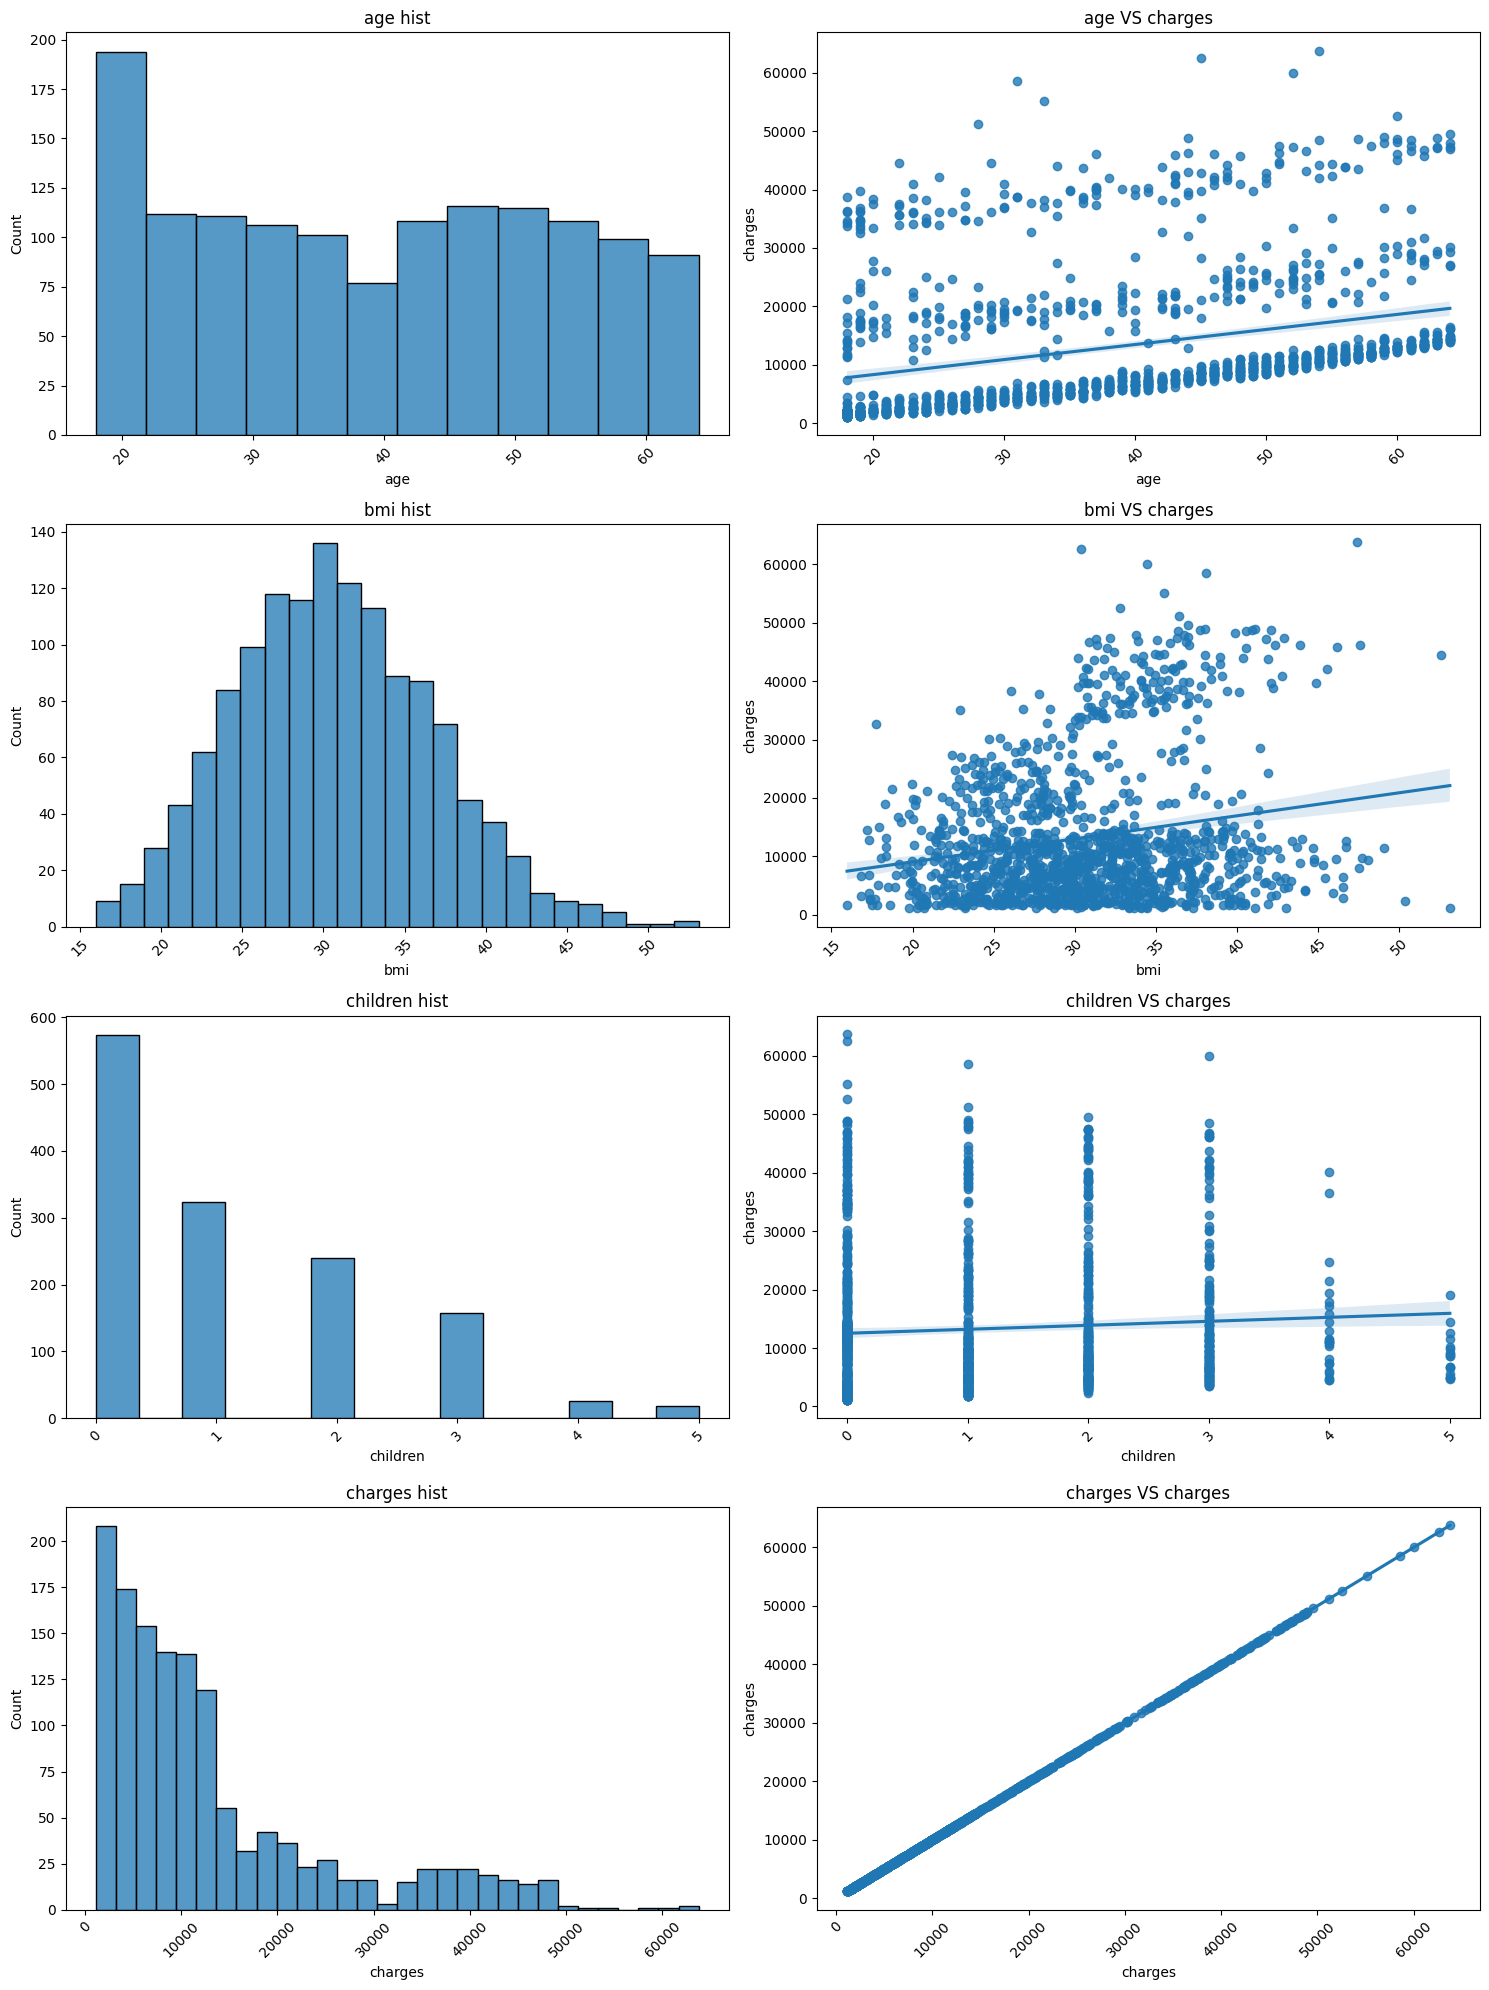

In [58]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data_copy, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data_copy, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

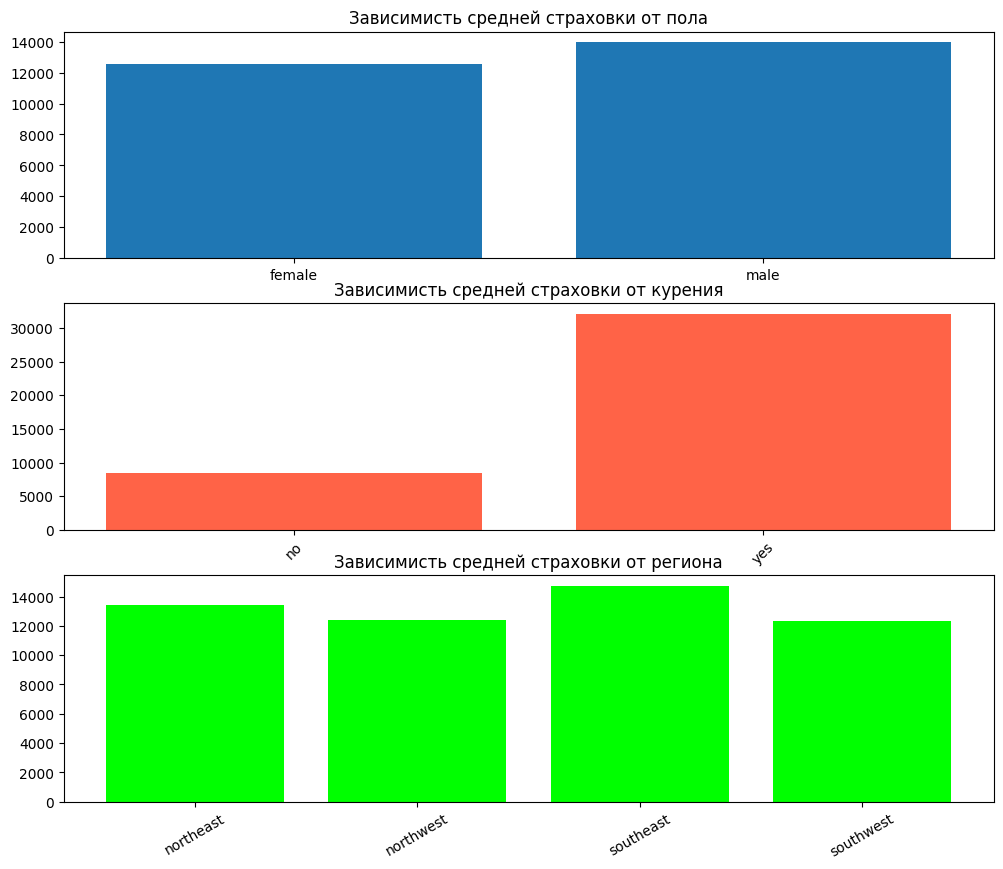

In [59]:
grouped_data = data_copy.groupby('sex')['charges'].mean()
grouped_data_by_smoke = data_copy.groupby('smoker')['charges'].mean()
grouped_by_region = data_copy.groupby('region')['charges'].mean()
fig, axes = plt.subplots(ncols =1, nrows =3, figsize=(12,10))
axes[0].bar(
    x=grouped_data.index,
    height= grouped_data,
)
axes[0].set_title("Зависимисть средней страховки от пола")


axes[1].bar(
    x = grouped_data_by_smoke.index,
    height = grouped_data_by_smoke,
    color="tomato"
)
axes[1].set_title("Зависимисть средней страховки от курения")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].bar(
    x= grouped_by_region.index, 
    height = grouped_by_region, 
    color="lime"
)
axes[2].set_title("Зависимисть средней страховки от региона")
axes[2].xaxis.set_tick_params(rotation=30)


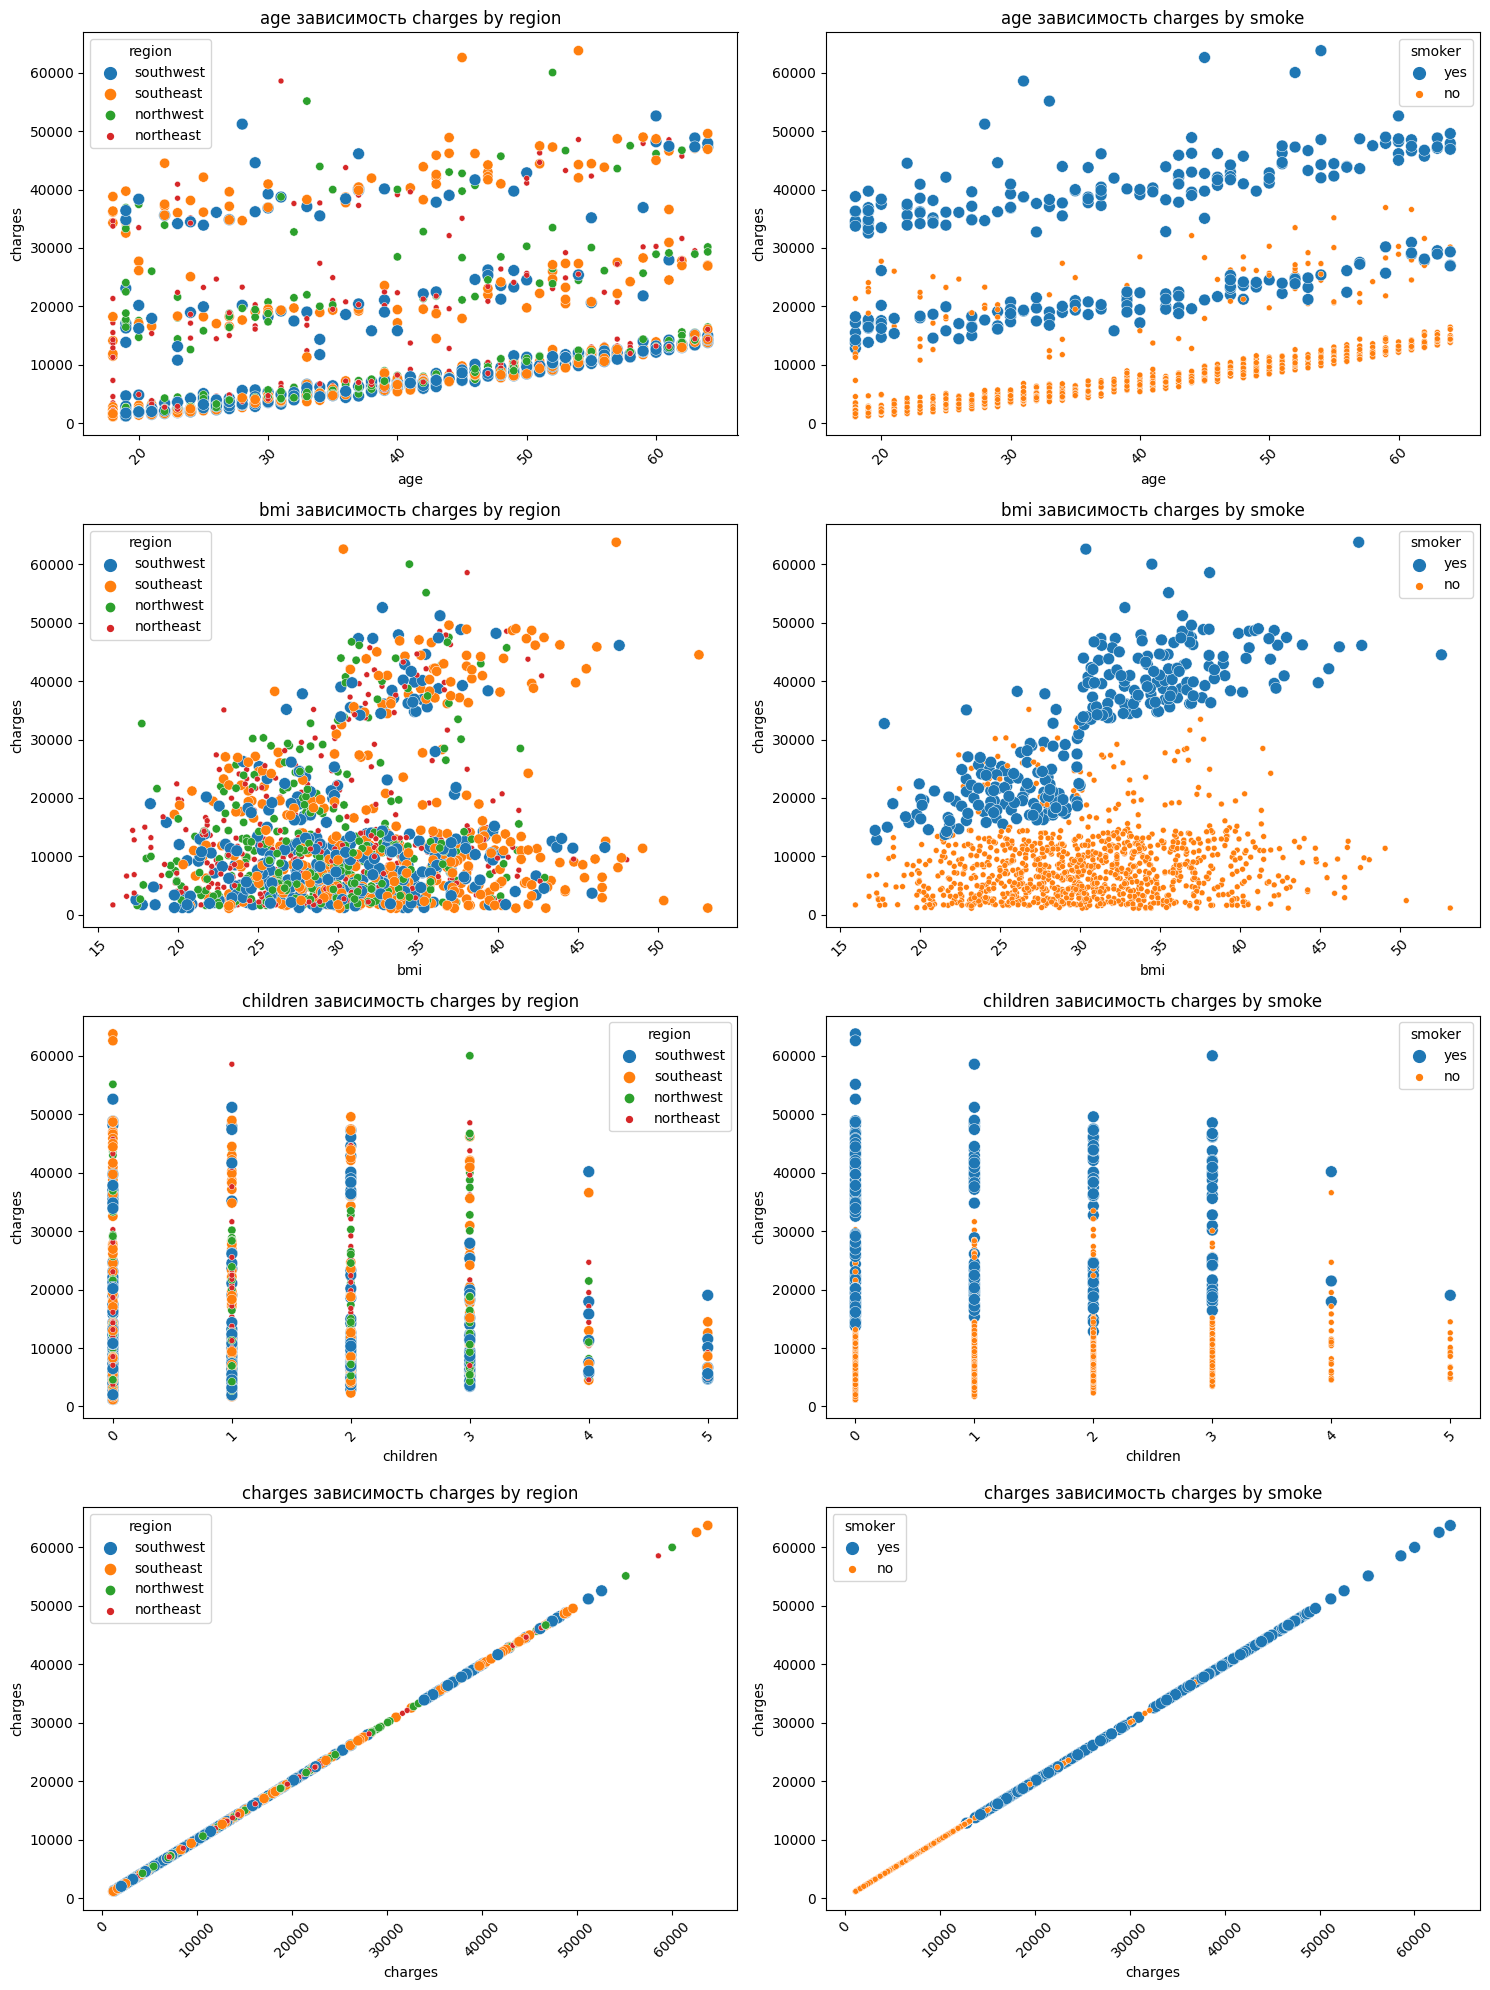

In [60]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим диаграмму рассеивания 
    scatter_sex = sns.scatterplot(
        data = data_copy,
        x= feature,
        y= 'charges',
        size= 'region',
        marker ='o',
        c = 'r', 
        hue= 'region',
        ax=axes[i][0]
    )
    #Добавляем подпись графику
    scatter_sex.set_title('{} зависимость charges by region'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    scatter_sex.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеивания
    scatter_region = sns.scatterplot(
        data = data_copy,
        x= feature,
        y= 'charges',
        size= 'smoker',
        hue = 'smoker',
        marker='o', ax=axes[i][1]
    )
    #Добавляем подпись графику
    scatter_region.set_title('{} зависимость charges by smoke'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    scatter_region.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [61]:
# произведем кодироку категориальных признаков
data_copy['smoker'] = data_copy['smoker'].apply(lambda x: 0 if x =='no' else 1)
data_copy['sex'] = data_copy['sex'].apply(lambda x: 0 if x == 'female' else 1)
# оставшиеся категориальные признаки кодируем как OneHotEncoding
data_copy = pd.get_dummies(data_copy)
data_copy.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [62]:
# Выыделим целевой признак в отдельную таблицу
features = data_copy.drop('charges', axis=1).columns
X, y = data_copy[features], data_copy['charges']

In [63]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [64]:
# Создадим функцию для вывода переменных
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [66]:
# обучим имеющуюся модель по методу линейной регрессии
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)
print('w0: {:.3f}'.format(lr.intercept_)) #свободный член w0


Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888
w0: -12390.804


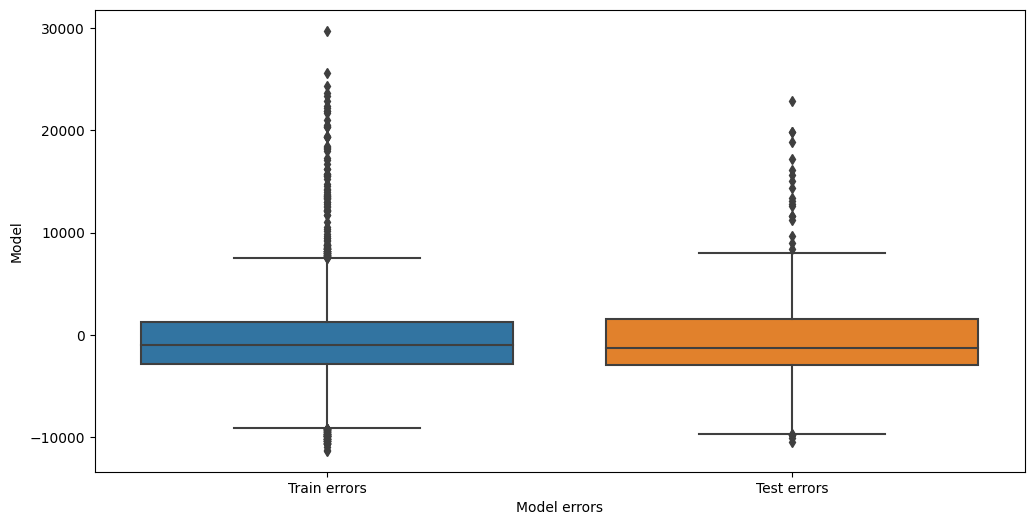

In [69]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [72]:
# Нормализуем данные при помощи MinMaxScaller
scaler = preprocessing.MinMaxScaler()
# нормализуем
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# создадим полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [75]:
# Обучим модель с полиномиальными признаками

lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)


Train R^2: 0.842
Train MAE: 2906.120
Train MAPE: 29.615


Test R^2: 0.867
Test MAE: 2741.678
Train MAPE: 30.411


In [76]:
print(lr_poly.coef_)

[-3.51760358e+16  1.61021746e+15  2.47615914e+15 -4.81004112e+15
  1.29275952e+14 -3.52012791e+15 -2.48431178e+15 -2.59881721e+15
 -1.45044066e+15  8.44800000e+03  8.02000000e+02  9.72000000e+02
 -1.67600000e+03  1.70000000e+02  3.51760358e+16  3.51760358e+16
  3.51760358e+16  3.51760358e+16 -9.23535566e+14  6.51750000e+02
 -1.23750000e+03  2.63000000e+02 -6.86681899e+14 -6.86681899e+14
 -6.86681899e+14 -6.86681899e+14 -9.69775000e+03  1.55693750e+03
  5.48399844e+04 -2.47615914e+15 -2.47615914e+15 -2.47615914e+15
 -2.47615914e+15 -2.09825000e+03 -2.23150000e+03  4.81004112e+15
  4.81004112e+15  4.81004112e+15  4.81004112e+15  2.54047741e+13
 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14 -1.54680726e+14
 -1.14203819e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.17785432e+15  0.00000000e+00  0.00000000e+00 -2.06334889e+15
  0.00000000e+00 -3.21172544e+15]


In [79]:
# ПРоведем регуляризацию для модели Lasso
lr_lasso_poly = linear_model.Lasso(max_iter=2000)
lr_lasso_poly.fit(X_train_scaled_poly, y_train)
# Сделаем предсказания для тренировочной выборки
y_train_predict_poly_2 = lr_lasso_poly.predict(X_train_scaled_poly)
# Сделаем предсказания дл тестовой выборки
y_test_predict_poly_2 = lr_lasso_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict_poly_2, y_test, y_test_predict_poly_2)


Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


In [80]:
# регуляция L-2
lr_ridge_poly = linear_model.Ridge()
lr_ridge_poly.fit(X_train_scaled_poly, y_train)
y_train_predict_ridge = lr_ridge_poly.predict(X_train_scaled_poly)
y_test_predict_ridge = lr_ridge_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict_ridge, y_test, y_test_predict_ridge)


Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
